In [1]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import mlflow
import mlflow.keras
import ta

**Load dataset and inspect**

In [2]:
data = pd.read_csv("./src/data/BTC-USD.csv")

# Display basic information about the dataset
print("Basic Information:")
print(data.info())

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Validate data distribution across the dataset
n = len(data)
train_end = int(0.7 * n)
val_end = int(0.9 * n)

data['Price_Change'] = data['Close'].diff()

data['Price_Trend'] = data['Price_Change'].apply(lambda x: 'Increase' if x > 0 else 'Decrease')

train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

train_distribution = train_data['Price_Trend'].value_counts()
val_distribution = val_data['Price_Trend'].value_counts()
test_distribution = test_data['Price_Trend'].value_counts()

distribution_df = pd.DataFrame({
    'Price Trend': ['Increase', 'Decrease'],
    'Training': [train_distribution.get('Increase', 0), train_distribution.get('Decrease', 0)],
    'Validation': [val_distribution.get('Increase', 0), val_distribution.get('Decrease', 0)],
    'Test': [test_distribution.get('Increase', 0), test_distribution.get('Decrease', 0)]
})

print(distribution_df)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3522 non-null   object 
 1   Open       3522 non-null   float64
 2   High       3522 non-null   float64
 3   Low        3522 non-null   float64
 4   Close      3522 non-null   float64
 5   Adj Close  3522 non-null   float64
 6   Volume     3522 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 192.7+ KB
None
  Price Trend  Training  Validation  Test
0    Increase      1341         342   183
1    Decrease      1124         362   170


**Feature Engineering**

In [3]:
# Adding new features

data['Previous_Close'] = data['Close'].shift(1)

# Target Feature
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

# Variety of Trading Indicators
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()

data['EMA20'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
data['EMA100'] = ta.trend.EMAIndicator(data['Close'], window=100).ema_indicator()
data['EMA150'] = ta.trend.EMAIndicator(data['Close'], window=150).ema_indicator()

data['SMA50'] = ta.trend.SMAIndicator(close=data['Close'], window=50).sma_indicator()

data['Momentum'] = ta.momentum.ROCIndicator(close=data['Close'], window=10).roc()

data['ROC'] = ta.momentum.ROCIndicator(close=data['Close'], window=12).roc()

bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['Bollinger_Middle'] = bollinger.bollinger_mavg()
data['Bollinger_Upper'] = bollinger.bollinger_hband()
data['Bollinger_Lower'] = bollinger.bollinger_lband()

macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()

Text(0.5, 1.0, 'Correlation matrix between old and new features')

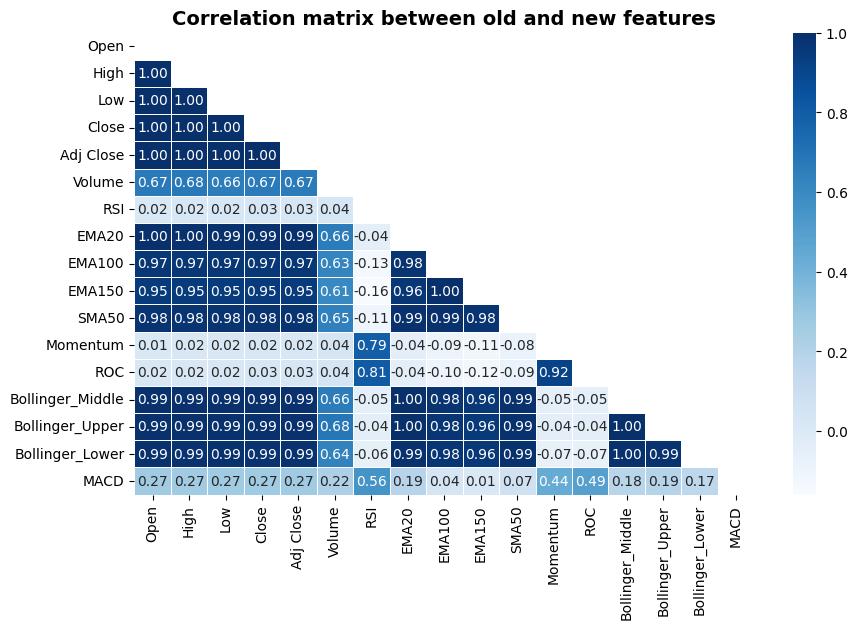

In [4]:
# Correlation Matrix
corr = data[['Open', 'High','Low', 'Close','Adj Close', 'Volume', 'RSI', 'EMA20', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Middle', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask,
            linewidths=0.5, linecolor='white')
plt.title('Correlation matrix between old and new features', fontsize=14, fontweight='bold')

In [5]:
# Keep only relevant features
data.drop(['High', 'Low', 'Adj Close', 'Volume','Open', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Upper', 'Bollinger_Lower'], axis=1, inplace=True)
data.dropna(inplace=True)

**Data Preperation**

In [6]:
# Selecting and scaling relevant features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [7]:
#Creating new experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("BTC Price Movement Prediction")


learning_rates = [0.001, 0.003, 0.005, 0.007, 0.01]
seq_lengths = [10, 30, 50]
epochs = 30
batch_size = 32

# Split data into train, validation and test + reshaping 
def prepare_data(seq_length):
    X, y = create_sequences(scaled_features, data['Target'].values, seq_length)
    train_size = int(0.7 * len(X))
    val_size = int(0.2 * len(X))
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    return X_train, X_val, X_test, y_train, y_val, y_test

**Model building, training and prediction**

In [ ]:
for lr in learning_rates:
    for seq_length in seq_lengths:
        with mlflow.start_run():
            
            params = {
                "learning_rate": lr,
                "epochs": epochs,
                "batch_size": batch_size,
                "seq_length": seq_length
            }
            mlflow.log_params(params)

            
            X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(seq_length)           
            optimizer = Adam(learning_rate=lr)

            # Model architecture
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, len(selected_features))))
            model.add(MaxPooling1D(pool_size=2))
            model.add(LSTM(units=50, activation='relu', return_sequences=True))
            model.add(LSTM(units=50, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(units=1, activation='sigmoid'))

            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

            loss, accuracy = model.evaluate(X_test, y_test)
            print(f'Test Loss: {loss}')
            print(f'Test Accuracy: {accuracy}')

            mlflow.log_metric("loss", loss)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.keras.log_model(model, "model")

            # Prediction making and converting into binary
            predictions = (model.predict(X_test) > 0.5).astype(int)

            mlflow.set_tag("model", "CNN-LSTM")


**Visual representation**

In [ ]:
# Accuracy and hyperparameters
experiment_name = "BTC Price Movement Prediction"
experiment = mlflow.get_experiment_by_name(experiment_name)
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

runs_df['params.learning_rate'] = runs_df['params.learning_rate'].astype(float)
runs_df['metrics.accuracy'] = runs_df['metrics.accuracy'].astype(float)
runs_df['params.seq_length'] = runs_df['params.seq_length'].astype(int)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(runs_df['params.learning_rate'], runs_df['metrics.accuracy'],
                      s=runs_df['params.seq_length']*10, 
                      c=runs_df['params.seq_length'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Impact of different hyperparameter values')
plt.grid(True)

cbar = plt.colorbar(scatter)
cbar.set_label('Sequence Length')

plt.show()

In [ ]:
# Confusion matrix
run_id = "799f2cf52e90475ebb91ab08a3da8b2c" #change for new best run id!
model_uri = f"runs:/{run_id}/model"
model = mlflow.keras.load_model(model_uri)

predictions = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Falling", "Rising"])
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

tick_marks = np.arange(len(disp.display_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(['False Falling', 'True Rising'])
ax.set_yticklabels(['True Falling', 'False Rising'])

plt.show()